# Projeto 1 - Ciência dos Dados

Nome: Ivan de Alcântara Barbosa Barros

Nome: Jamesson Leandro Paiva Santos

**Atenção:** Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

**Em `filename`, coloque o nome do seu arquivo de dados!**

In [2]:
import os

filename = 'guarana_jesus.xlsx'
if filename in os.listdir():
    print(f'Encontrei o arquivo {filename}, tudo certo para prosseguir com a prova!')
else:
    print(f'Não encontrei o arquivo {filename} aqui no diretório {os.getcwd()}, será que você não baixou o arquivo?')

Encontrei o arquivo guarana_jesus.xlsx, tudo certo para prosseguir com a prova!


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
# Carrega dataset de treino
train = pd.read_excel(filename)
train.head(5)

Treinamento  Classificação
0  rt @giussilvestre: os éguas que tão cancelando...              0
1  @whindersson @lilwhind guaraná jesus... show d...              1
2                   bissexuais tomando guarana jesus              0
3  @whindersson @lilwhind guaraná jesus é tipo al...              0
4  rt @maickjhonn: piaui nem tem guaraná jesus is...              0

In [4]:
# Carrega dataset de teste
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

Teste  Classificação
0       foda que ela é coca-cola e eu guaraná jesus😫              1
1  @niyeongs @tealcookie eu gostei de pernambuco ...              0
2  rt @botbissexual: bissexuais tomando guarana j...              0
3  a bandeira do estado do cara parece mais uma l...              0
4  rt @marilhera: @inesteticas cajuína meets guar...              0

In [5]:
type(train)

pandas.core.frame.DataFrame

In [6]:
serie_0 = train[train["Classificação"] == 0]
serie_1 = train[train["Classificação"] == 1]

series = [serie_0, serie_1]

In [7]:
str(list(series[0]["Treinamento"].values))
str(list(series[1]["Treinamento"].values))
print('OK')

OK


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

ESCREVA AQUI...

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

### Limpeza do dataset

In [15]:
!pip install emoji wordcloud
from emoji import UNICODE_EMOJI
import emoji
import re 
import functools
import operator
import nltk
import re

In [26]:
def clean_tweet(texto):
    """
    Essa função define um padrão de pontuações que serão
    removidas do texto de entrada.
    """
    caracteres = '[\-/!.:?;,''"@]'
    padrao = re.compile(caracteres)
    texto_limpo = re.sub(padrao, '', texto)
    texto_limpo = re.sub(' +', ' ', texto_limpo)
    texto_limpo = emoji.get_emoji_regexp().split(texto_limpo)
    separa = [texto.split() for texto in texto_limpo]
    texto_limpo = functools.reduce(operator.concat, separa)
    return texto_limpo

# Limpeza dos dados (pontuação, '\n', 'rt', letras minúsculas)

def remove_outros_itens(lista):

    i = 0
    while i < len(lista):

        lista[i] = lista[i].lower()
        lista[i] = lista[i].replace('[\n]', '')
        
        if lista[i][0:2] == 'rt':
            lista[i] = lista[i][3:]
                
        elif lista[i][:4] == 'http':
            del lista[i]
            
        i+=1

    return lista

In [27]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords.append('')

def remove_stopwords(lista):
    filtrada = lista[:] 
    
    for palavra in lista: 
          if palavra in stopwords: 
                filtrada.remove(palavra)           
    
    return filtrada

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ivanabb2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def limpeza_da_serie(serie):
    limpo = []
    
    for tweet in serie["Treinamento"]:
        limpo.append(remove_stopwords(remove_outros_itens(clean_tweet(tweet))))
        
    return limpo

series_tweets = [limpeza_da_serie(series[0]), limpeza_da_serie(series[1])]

serie_pd = limpeza_da_serie(train)

for i in range(len(serie_pd)):
    serie_pd[i] = ', '.join(serie_pd[i])

train['Pré Processado'] = serie_pd

train.head()

Treinamento  Classificação  \
0  rt @giussilvestre: os éguas que tão cancelando...              0   
1  @whindersson @lilwhind guaraná jesus... show d...              1   
2                   bissexuais tomando guarana jesus              0   
3  @whindersson @lilwhind guaraná jesus é tipo al...              0   
4  rt @maickjhonn: piaui nem tem guaraná jesus is...              0   

                                      Pré Processado  
0  giussilvestre, éguas, tão, cancelando, thaynar...  
1  whindersson, lilwhind, guaraná, jesus, show, b...  
2                bissexuais, tomando, guarana, jesus  
3  whindersson, lilwhind, guaraná, jesus, tipo, a...  
4  maickjhonn, piaui, guaraná, jesus, apropriação...

In [28]:
def laplace(quantidade_na_serie, total_serie, total):
    return (quantidade_na_serie + 1)/(total_serie + total)

In [29]:
def vezes_que_aparece(palavra, serie):
    quant = 0
    for tweet in serie:
        quant += tweet.count(palavra)
    return quant

def total_na_serie(serie):
    quant = 0
    for tweet in serie:
        quant += len(tweet)
    return quant

def lista_palavras(lista1, lista2):
    quant = []
    for tweet in lista1:
        for palavra in tweet:
            if palavra not in quant:
                quant.append(palavra)                
    for tweet in lista2:
        for palavra in tweet:
            if palavra not in quant:
                quant.append(palavra)            
    return quant

total = len(lista_palavras(series_tweets[0],series_tweets[1]))

In [30]:
probs = []
for serie in series_tweets:
    dicio = {}
    for tweet in serie:
        for palavra in tweet:
            dicio[palavra] = laplace(vezes_que_aparece(palavra, serie), len(serie), total)
    probs.append(pd.Series(dicio))

<Figure size 3600x2400 with 0 Axes>

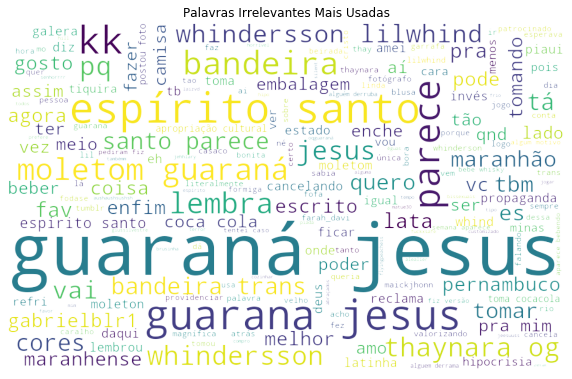

In [31]:
from wordcloud import WordCloud

irrelevant_words =' '.join([text for text in train['Pré Processado'][train['Classificação'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(irrelevant_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Palavras Irrelevantes Mais Usadas")
plt.show()

<Figure size 3600x2400 with 0 Axes>

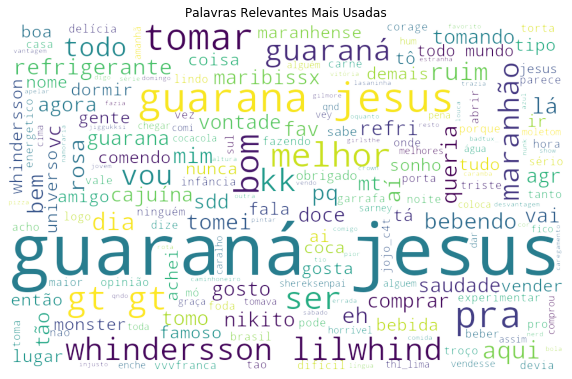

In [32]:
relevant_words =' '.join([text for text in train['Pré Processado'][train['Classificação'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(relevant_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Palavras Relevantes Mais Usadas")
plt.show()

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [33]:
def limpando(tweet):
    limpo = remove_stopwords(remove_outros_itens(clean_tweet(str(tweet))))
    return limpo

test_tweets = []
for tweet in test['Teste']:
    test_tweets.append(limpando(tweet))
    
series_test = pd.Series(test_tweets)

test['Pré Processado'] = series_test

In [34]:
def compara(frase):
    prob_serie_0 = 1
    prob_serie_1 = 1

    for palavra in frase:
        if (palavra not in probs[0].index):
            prob_serie_0 *= laplace(0, total_na_serie(series_tweets[0]), total)
        else: 
            prob_serie_0 *= probs[0][palavra]

    for palavra in frase:
        if (palavra not in probs[1].index):
            prob_serie_1 *= laplace(0, total_na_serie(series_tweets[1]), total) 
        else:
            prob_serie_1 *= probs[1][palavra]
            
    if prob_serie_0 > prob_serie_1:
        return 0
    else:
        return 1

In [35]:
def conclusao(coluna_df, n):
    return compara(coluna_df[n])

In [36]:
Classificação_modelo = []
for i in range(0, len(test['Teste'])):
    Classificação_modelo.append(conclusao(test['Pré Processado'], i))

In [37]:
test["Naive Bayes"] = Classificação_modelo

In [38]:
pd.crosstab(test['Classificação'], test['Naive Bayes'], normalize = True)

Naive Bayes           0         1
Classificação                    
0              0.372671  0.149068
1              0.118012  0.360248

In [59]:
serie_0_test = test[test["Classificação"] == 0]
serie_1_test = test[test["Classificação"] == 1]

verdadeiros_positivos = 0
falsos_positivos = 0
verdadeiros_negativos = 0
falsos_negativos = 0

for i in range(len(test['Classificação'])):
    if test['Classificação'][i] == 1 and test['Naive Bayes'][i] == 1:
        verdadeiros_positivos += 1
    elif test['Classificação'][i] == 0 and test['Naive Bayes'][i] == 1:
        falsos_positivos += 1
    elif test['Classificação'][i] == 0 and test['Naive Bayes'][i] == 0:
        verdadeiros_negativos += 1
    elif test['Classificação'][i] == 1 and test['Naive Bayes'][i] == 0:
        falsos_negativos += 1
        
print("Contagem\t\tProbabilidade")
print("----------------------------------------")
print("%s:\t\t%f" % ('Verdadeiros Positivos', verdadeiros_positivos/len(serie_1_test['Classificação'])))
print("%s:\t\t%f" % ('Falsos Positivos', falsos_positivos/len(serie_0_test['Classificação'])))
print("%s:\t\t%f" % ('Verdadeiros Negativos', verdadeiros_negativos/len(serie_0_test['Classificação'])))
print("%s:\t\t%f" % ('Falsos Negativos', falsos_negativos/len(serie_1_test['Classificação'])))

Contagem		Probabilidade
----------------------------------------
Verdadeiros Positivos:		0.753247
Falsos Positivos:		0.285714
Verdadeiros Negativos:		0.714286
Falsos Negativos:		0.246753


___
### Concluindo

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que realiza análise de sentimento e visualiza estes dados

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**